### Imports

In [1]:
!pip install -r requirements.txt    

In [2]:
import random
import numpy as np
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, random_split, \
WeightedRandomSampler, SubsetRandomSampler
from torchvision.transforms import Compose, ToTensor, Normalize,\
ToPILImage, RandomHorizontalFlip, Resize

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

from data_generation.image_classification import generate_dataset
from stepbystep.v0 import StepByStep

### Data generation

In [3]:
images, labels = generate_dataset(img_size=5, n_images=300, binary=True, seed=13)

In [4]:
images.shape

(300, 1, 5, 5)

In [5]:
images[1:3]

array([[[[  0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0],
         [  0,   0,   0,   0, 255]]],


       [[[  0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0],
         [  0,   0,   0,   0, 255]]]], dtype=uint8)

In [6]:
example = images[7]
example,example.shape

(array([[[  0, 255,   0,   0,   0],
         [  0,   0, 255,   0,   0],
         [  0,   0,   0, 255,   0],
         [  0,   0,   0,   0, 255],
         [  0,   0,   0,   0,   0]]], dtype=uint8),
 (1, 5, 5))

In [7]:
example_hwc = np.transpose(example,(1,2,0))
example_hwc.shape

(5, 5, 1)

### Transforms

In [8]:
tensorizer = ToTensor()
example_tensor = tensorizer(example_hwc)
example_tensor.shape

torch.Size([1, 5, 5])

In [9]:
example_hwc.shape

(5, 5, 1)

In [10]:
example_tensor

tensor([[[0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]])

In [11]:
example_img = ToPILImage()(example_tensor)
print(type(example_img))

<class 'PIL.Image.Image'>


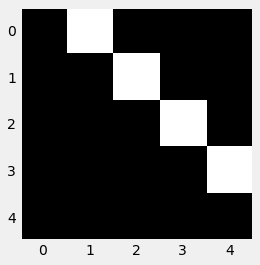

In [12]:
plt.imshow(example_img, cmap='gray')
plt.grid(False)

### Transforms on images

In [13]:
flipper = RandomHorizontalFlip(p=1.0)
flipped_img = flipper(example_img)

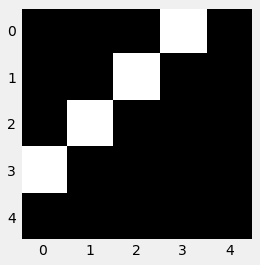

In [14]:
plt.imshow(flipped_img,cmap='gray')
plt.grid(False)

### Transforms on tensors

In [15]:
img_tensor = tensorizer(flipped_img)
img_tensor

tensor([[[0., 0., 0., 1., 0.],
         [0., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]])

In [16]:
normalizer = Normalize(mean = (.5,),std = (.5,))
normalized_img = normalizer(img_tensor)
normalized_img

tensor([[[-1., -1., -1.,  1., -1.],
         [-1., -1.,  1., -1., -1.],
         [-1.,  1., -1., -1., -1.],
         [ 1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.]]])

### Composing transforms

In [17]:
composer = Compose([RandomHorizontalFlip(p=1.0),Normalize(mean = (.5,),std = (.5,))])

In [18]:
composed_tensor = composer(example_tensor)
composed_tensor == normalized_img

tensor([[[True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True]]])

In [19]:
example_tensor

tensor([[[0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]])

In [20]:
example

array([[[  0, 255,   0,   0,   0],
        [  0,   0, 255,   0,   0],
        [  0,   0,   0, 255,   0],
        [  0,   0,   0,   0, 255],
        [  0,   0,   0,   0,   0]]], dtype=uint8)

### Data preparation

In [21]:
x_tensor = torch.as_tensor(images/255).float()
y_tensor = torch.as_tensor(labels.reshape(-1,1)).float()

#### Dataset Transforms

In [22]:
class TransformedTensorDataset(Dataset):
    def __init__(self,x,y,transform = None):
        self.x = x
        self.y = y
        self.transform = transform

    def __getitem__(self, index):
        x = self.x[index]

        if self.transform:
            x = self.transform(x)
        
        return x,self.y[index]
    
    def __len__(self):
        return len(self.x)

In [23]:
composer = Compose([RandomHorizontalFlip(p=0.5),
                    Normalize(mean = (0.5,),std = (0.5,))])

In [24]:
dataset = TransformedTensorDataset(x_tensor,y_tensor,transform = composer)

In [25]:
def index_splitter(n,splits,seed = 13):

    idx = torch.arange(n)

    splits_tensor = torch.as_tensor(splits)
    multiplier = n/splits_tensor.sum()
    splits_tensor = (multiplier * splits_tensor).long()

    diff = n - splits_tensor.sum()
    splits_tensor[0] += diff

    torch.manual_seed(seed)
    return random_split(idx,splits_tensor)

In [26]:
train_idx , val_idx = index_splitter(len(x_tensor),[80,20])
train_idx

In [27]:
train_idx.indices

[118,
 170,
 148,
 239,
 226,
 146,
 168,
 195,
 6,
 180,
 157,
 2,
 160,
 66,
 46,
 276,
 126,
 212,
 119,
 77,
 53,
 237,
 252,
 202,
 200,
 289,
 135,
 186,
 231,
 211,
 35,
 293,
 229,
 265,
 256,
 134,
 191,
 214,
 8,
 83,
 150,
 190,
 208,
 209,
 275,
 60,
 295,
 142,
 251,
 176,
 260,
 3,
 31,
 0,
 137,
 20,
 81,
 287,
 181,
 129,
 166,
 97,
 110,
 206,
 267,
 241,
 109,
 177,
 27,
 52,
 43,
 245,
 247,
 141,
 68,
 131,
 217,
 78,
 185,
 49,
 96,
 14,
 111,
 234,
 284,
 263,
 269,
 101,
 32,
 285,
 79,
 297,
 94,
 85,
 11,
 5,
 80,
 165,
 183,
 4,
 33,
 100,
 73,
 235,
 277,
 16,
 144,
 132,
 167,
 130,
 45,
 48,
 201,
 99,
 34,
 138,
 178,
 244,
 225,
 173,
 95,
 22,
 197,
 174,
 90,
 223,
 274,
 92,
 279,
 19,
 74,
 28,
 162,
 133,
 151,
 37,
 299,
 18,
 203,
 13,
 156,
 268,
 259,
 116,
 70,
 71,
 230,
 108,
 238,
 47,
 163,
 30,
 188,
 64,
 216,
 121,
 187,
 72,
 221,
 258,
 44,
 179,
 272,
 159,
 253,
 280,
 140,
 120,
 62,
 271,
 57,
 1,
 149,
 9,
 29,
 194,
 158,
 115,
 1

In [28]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [29]:
train_loader = DataLoader(dataset = dataset,batch_size=16,sampler= train_sampler)
val_loader = DataLoader(dataset=dataset,batch_size=16,sampler=val_sampler)

In [30]:
len(iter(train_loader)),len(iter(val_loader))

(15, 4)

In [31]:
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

In [32]:
train_composer = Compose([RandomHorizontalFlip(p=.5),
                          Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])

In [33]:
train_dataset = TransformedTensorDataset(
    x_train_tensor, y_train_tensor, transform=train_composer
)
val_dataset = TransformedTensorDataset(
    x_val_tensor, y_val_tensor, transform=val_composer
)
# Builds a loader of each set
train_loader = DataLoader(
    dataset=train_dataset, batch_size=16, shuffle=True
)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

#### Weighted Random Sampler

In [34]:
classes, counts = y_train_tensor.unique(return_counts=True) 
print(classes, counts)

tensor([0., 1.]) tensor([ 80, 160])


In [35]:
weights = 1.0 / counts.float()
weights

tensor([0.0125, 0.0063])

In [36]:
sample_weights = weights[y_train_tensor.squeeze().long()]

In [37]:
sample_weights[:10],y_train_tensor[:10]

(tensor([0.0063, 0.0063, 0.0063, 0.0063, 0.0063, 0.0125, 0.0063, 0.0063, 0.0063,
         0.0063]),
 tensor([[1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [0.],
         [1.],
         [1.],
         [1.],
         [1.]]))

In [38]:
generator = torch.Generator()

sampler = WeightedRandomSampler(weights=sample_weights
                                ,num_samples=len(sample_weights),
                                replacement=True,
                                generator = generator)

In [39]:
def make_balanced_sampler(y):
    # Computes weights for compensating imbalanced classes classes, counts = y.unique(return_counts=True)
    weights = 1.0 / counts.float()
    sample_weights = weights[y.squeeze().long()]
    # Builds sampler with compute weights
    generator = torch.Generator()
    sampler = WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(sample_weights),
            generator=generator,
            replacement=True)
    return sampler 

sampler = make_balanced_sampler(y_train_tensor)

In [40]:
train_loader = DataLoader(
    dataset=train_dataset, batch_size=16,  sampler=sampler)
    
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

In [41]:
train_loader.sampler.generator.manual_seed(42)
random.seed(42)

In [42]:
torch.tensor([t[1].sum() for t in iter(train_loader)]).sum()

tensor(123.)

#### Pixels as features

In [43]:
dummy_xs, dummy_ys = next(iter(train_loader))
dummy_xs.shape

torch.Size([16, 1, 5, 5])

In [44]:
flattener = nn.Flatten()
dummy_xs_flat = flattener(dummy_xs)

dummy_xs_flat.shape

torch.Size([16, 25])

### Shallow model

In [45]:
lr = 0.1

torch.manual_seed(17)

model_logistic = nn.Sequential()

model_logistic.add_module('Flatten',nn.Flatten())
model_logistic.add_module('Linear',nn.Linear(25,1,bias = False))
model_logistic.add_module('sigmoid',nn.Sigmoid())

optimizer_logistic = optim.SGD(model_logistic.parameters(),lr = lr)

binary_loss_fn = nn.BCELoss()

In [48]:
n_epochs = 100

from stepbystep.v1 import StepByStep

sbs_logistic = StepByStep(model_logistic,binary_loss_fn,optimizer_logistic)
sbs_logistic.set_loaders(train_loader,val_loader)
sbs_logistic.train(n_epochs)

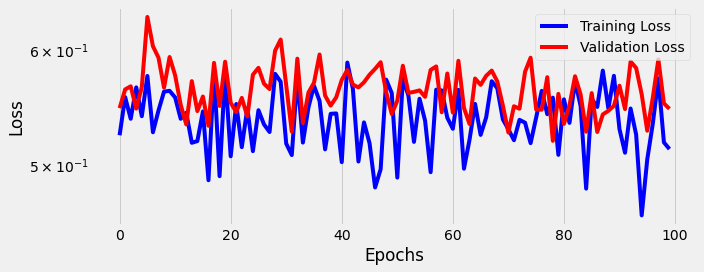

In [49]:
fig = sbs_logistic.plot_losses()

### Deep-ish  model

In [55]:
lr = 0.1

torch.manual_seed(17)

model_logistic = nn.Sequential()

model_logistic.add_module('Flatten',nn.Flatten())
model_logistic.add_module('hidden0',nn.Linear(25,5,bias = False))
model_logistic.add_module('hidden1',nn.Linear(5,3,bias=False))
model_logistic.add_module('output',nn.Linear(3,1,bias=False))
model_logistic.add_module('sigmoid',nn.Sigmoid())

optimizer_logistic = optim.SGD(model_logistic.parameters(),lr = lr)

binary_loss_fn = nn.BCELoss()

In [56]:
n_epochs = 100

# from stepbystep.v1 import StepByStep

sbs_logistic = StepByStep(model_logistic,binary_loss_fn,optimizer_logistic)
sbs_logistic.set_loaders(train_loader,val_loader)
sbs_logistic.train(n_epochs)

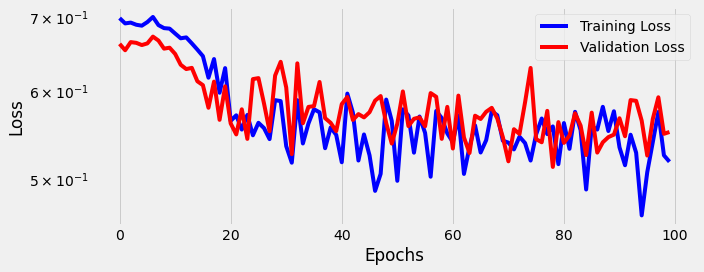

In [57]:
fig = sbs_logistic.plot_losses()

We can see both deeper model and shallow model perform equally bad. This is because we have not included activation 
functions in b/w hidden layers. So without act fns, a deeper model is more or less equivalent to a logistic regression model

In [58]:
model_logistic.hidden0.weight.detach().shape

torch.Size([5, 25])

### Deep model

In [59]:
lr = 0.1

torch.manual_seed(17)

model_deep = nn.Sequential()
model_deep.add_module('flatten',nn.Flatten())
model_deep.add_module('hidden0',nn.Linear(25,5,bias= False))
model_deep.add_module('act0',nn.ReLU())
model_deep.add_module('hidden1',nn.Linear(5,3,bias= False))
model_deep.add_module('act1',nn.ReLU())
model_deep.add_module('output',nn.Linear(3,1,bias= False))
model_deep.add_module('sigmoid',nn.Sigmoid())

optimizer_deep = optim.SGD(model_deep.parameters(),lr = lr)
binary_loss_fn = nn.BCELoss()

In [60]:
n_epochs = 50

sbs_deep = StepByStep(model_deep,binary_loss_fn,optimizer_deep)
sbs_deep.set_loaders(train_loader,val_loader)
sbs_deep.train(n_epochs)

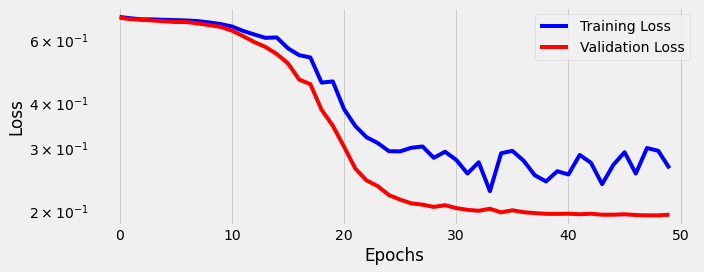

In [61]:
fig = sbs_deep.plot_losses()